# The Full Response Pipeline

In [1]:
import pandas as pd
import numpy as np
from Carl_load_responses import *
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, sosfiltfilt, welch
from numpy.fft import rfftfreq, rfft
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def norm(x):
  return (x - np.mean(x))

def readCsv(file_path):
  path = "Carl_preprocessed_responses/"
  return np.array(pd.read_csv(os.path.join(path,file_path), delimiter='\t', header=None))

This notebook details the full response pipeline. The steps in the pre-processing of the responses are as follows:
1) First, we are using only run 1 responses
2) We must remember that for the final task, we are examining which subacute patients progress to the chronic stage, so we may need to filter those patients which have 4 visits in the subacute - however for now, we smooth all responses for all visits.
3) First the responses should be smoothed to remove noise.
4) Next, due to the fact that many of the responses are different lengths, they should all be downsampled to the 244 length. This is so that regressors can be generated for the fMRI scans. 
5) These downsampled responses should be saved, with a list of the visits and the subjects, and a numpy array containing all of the responses. 
This will allow easier accessing of the responses for bulk regression later. 

In [2]:
def downsample_response(response, get_freqs = False):
  """This function aims to downsample responses to a length of 244.
   It does this by simplying sampling, if the response length is a multiple of 8784.
   However if it is not, then it has different rules."""
  length = len(response)
  if length == 244:
    downsample_response = response
    fs = float(1.0/2.5)
  elif length % 8784 == 0:
    downsample_response = response[::(length//8784)*36]
    fs = (length//8784) * 14.4
  elif length == 2196:
    downsample_response = response[::9]
    fs = 7.2
  elif length == 16711:
    print(f"I can't deal with this response length: {length}")
    raise ValueError(f"Bad response length {length}")
  elif 8784-length > 36:
    response_full = np.zeros(8784)
    response_full[:length] = response
    response_full[length:] = response[-1]
    downsample_response = response_full[::36]

    fs = 14.4
  else:
    downsample_response = response[:8784][::36]
    fs = 14.4

  if get_freqs:
    return fs
  else:
    return downsample_response


In [12]:
def low_pass_filter_response(subject,visit, run,response, fs=14.4, plot=True, plot_extra=False):
  """
  Low Pass filters a response.
  ### Parameters:
    subject - the subject to low pass filter
    plot - whether to plot the results of the filtering
  """
  #response = response - np.mean(response) # remove the 0 frequency peak, just in case this hasn't been done already
  n = len(response)
  freq = rfftfreq(n, d=1./fs)
  freqs, psd = welch(response,fs=fs)
  psd = np.abs(psd)
  power_percentages = np.cumsum(psd)/np.sum(psd)
  second = savgol_filter(power_percentages,11,4,2)
  cutoff_freq = freqs[np.where(second > 0-0.02)[0][0]]
  if cutoff_freq == 0:
    cutoff_freq = 0.4

  if plot_extra:
    plt.plot(freqs,power_percentages)
    plt.axvline(cutoff_freq, linestyle='dashed')
    plt.show()

    plt.plot(freqs, second, label='second derivative of power percentages')
    plt.axvline(cutoff_freq, linestyle='dashed')

    plt.show()

  sos = butter(10, cutoff_freq, 'lp', fs=fs, output='sos')
  filtered = sosfiltfilt(sos, response)
  
  if plot_extra:
    times = np.arange(n)*2.5/36
    FFT = rfft(response)

    fig, ax = plt.subplots(2,figsize=(10,6),dpi=500)
    ax[0].plot(times[4*36:],response[4*36:],label = 'Unsmoothed')
    # ax[0].set_xticks(times[4*36::36*8])
    # ax[0].set_xticklabels(np.arange(len(times[4*36::36]*36)))
    ax[0].set_xlabel("Seconds",fontsize=15)
    ax[0].set_ylabel("Pain Rating",fontsize=15)
    ax[1].plot(freqs,power_percentages,label='Cumulative PSD')
    ax[1].axvline(cutoff_freq, 0,1,linestyle='dashed',label='cutoff freq',color='red')
    ax[1].set_xlabel("Frequency (Hz)",fontsize=15)
    ax[1].set_ylabel("Signal Power %",fontsize=15)
    ax[1].legend()
    ax[0].plot(times[4*36:],filtered[4*36:],label='Smoothed')
    ax[0].legend()
    plt.suptitle(f"The Smoothed and Unsmoothed Response of subject {subject[-3:]}, visit {visit[-1]}",fontsize=15)
    plt.tight_layout()
    plt.show()
  elif plot:
    times = np.arange(n)*2.5/36
    FFT = rfft(response)

    fig, ax = plt.subplots(1,figsize=(20,2))
    ax.plot(times,response)
    ax.plot(times,filtered)
    plt.suptitle(f"The smoothed and un-smoothed response of subject {subject[-3]}, {run}, visit {visit[-1]}")
    plt.tight_layout()
    plt.show()

  return filtered

### An example of smoothing a response

loading the data of: 
      group race gender  age origin
97  chronic    6      M   35      2
len of responses:  8784


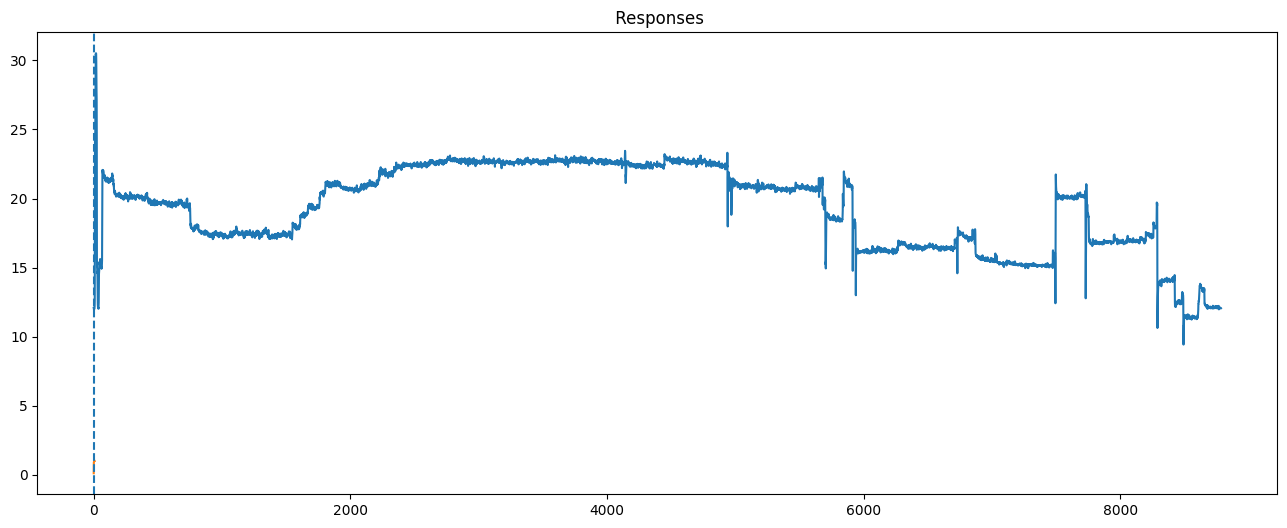

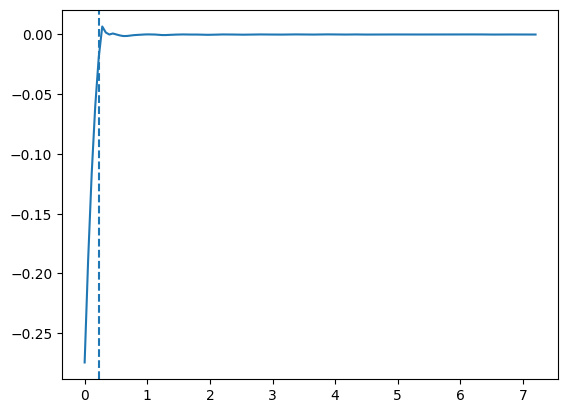

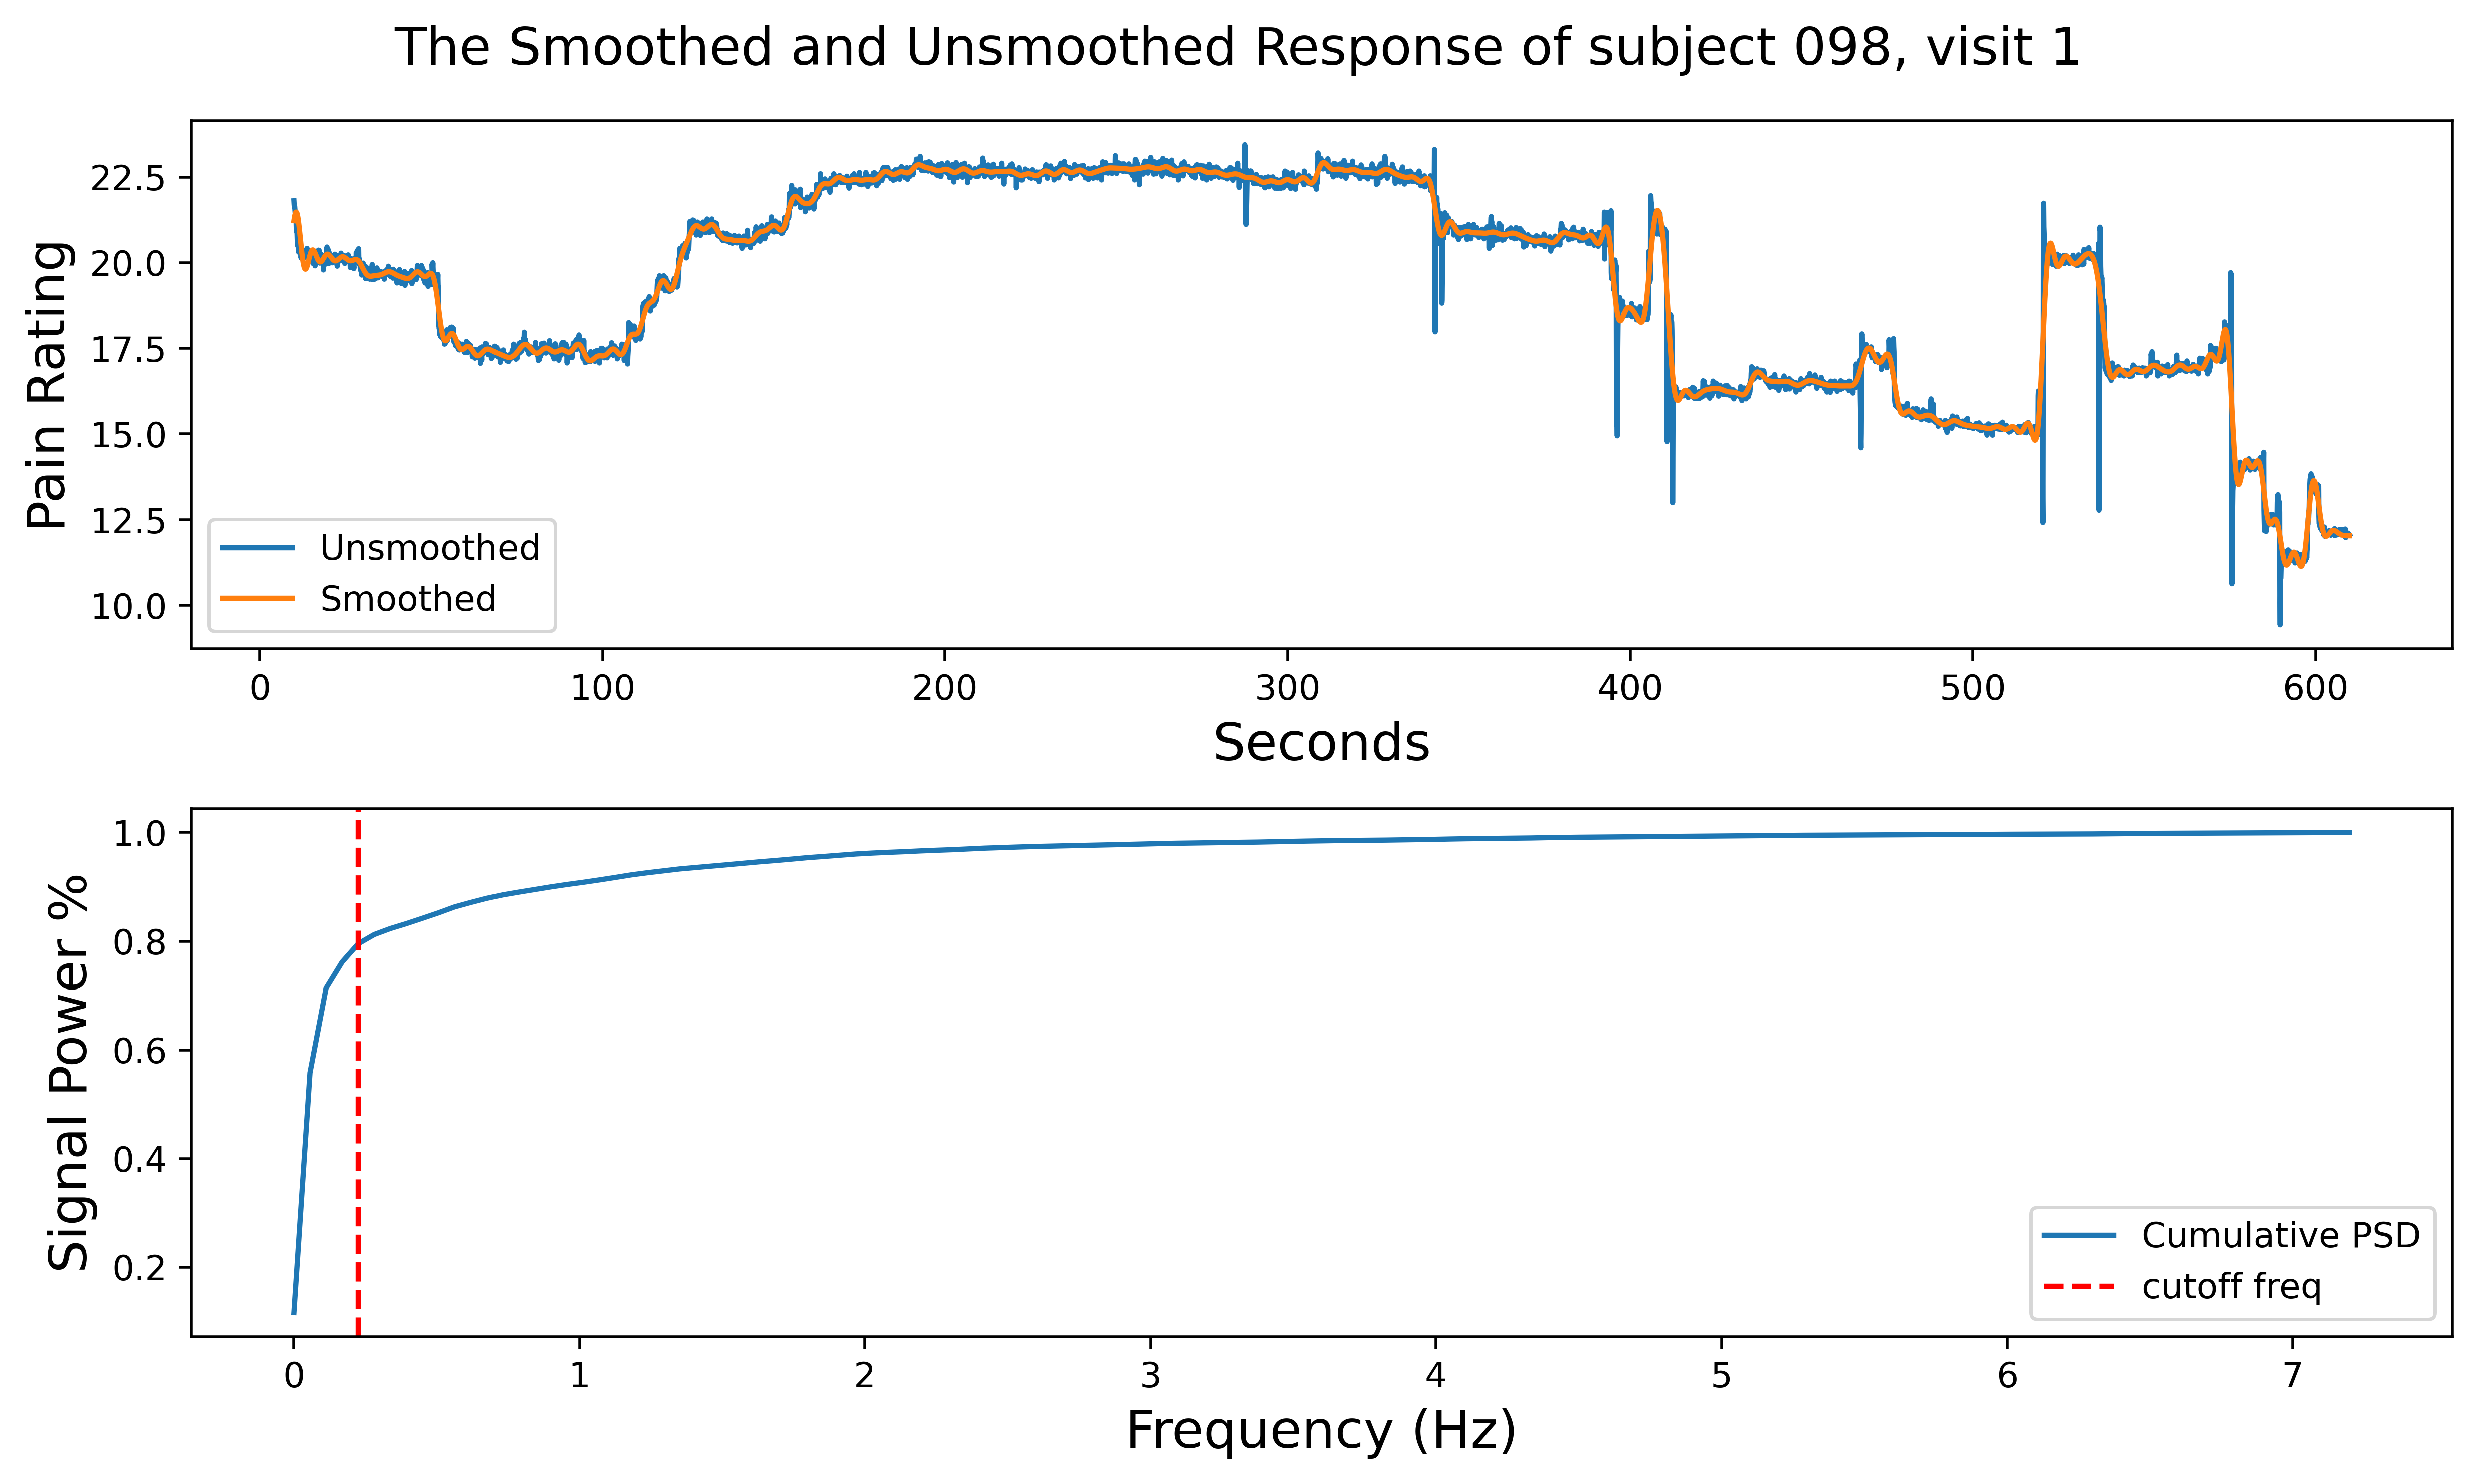

In [13]:
subject = 'sub-098'
visit = 'visit1'
run = 'run-01'
response = load_single_subject_response(subject,1, 1, plot=True,downsample=False)
smoothed_response = low_pass_filter_response(subject,visit,run,response, 14.4, plot=True, plot_extra=True)


In [ ]:
def run_full_response_pipeline():
  """Takes the sp_run_01 responses from all chronic and subacute patients, smooths them, downsamples them, and then stores the result in 
  a numpy array, with a separate array which links the rows of the array to the visits and subjects that the responses belong to."""

  # First get the chronic and subacute dataframes
  participants_df = pd.read_csv('openpain.org/subacute_longitudinal_study/participants.tsv', sep='\t')
  chronic_and_subacute_df = participants_df.loc[(participants_df["group"] == "chronic") | (participants_df["group"] == "subacute")]
  # Create an array to save the responses to, and a pandas df to store the visit, run, subject, and chronic/subacute
  responseArray = []
  unsmoothedResponseArray = []
  responseDetails = []
  
  # Now go through each subject and smooth response for run 1 and each visit using a smoothing method
  response_lengths = []
  for index, row in chronic_and_subacute_df.iterrows():
    subject = row['participant_id']
    group = row['group']
    responses_one_participant, key = get_all_responses_for_one_subject(subject,'sp',downsampled = False, verbose = False)
    for i, key in enumerate(key):
      visit, run = key.split(', ')
      if run == 'run_02':
          continue
      else:

        response = responses_one_participant[i]
        
        # Attempt to smooth and downsample the responses
        try:
          fs = downsample_response(response, get_freqs=True)
          if len(response) == 244:
            downsampled_response = response
          else:
            smoothed_response = low_pass_filter_response(subject,visit,run,response, fs, plot=False, plot_extra=False)
            downsampled_response = downsample_response(smoothed_response)
          responseArray.append(downsampled_response)
          responseDetails.append([subject, visit, run, group])
          unsmoothedResponseArray.append(downsample_response(response))
        except Exception as err:
          plt.plot(response)
          plt.show()
          print(err, subject, visit, run)

  #now convert the response lists to arrays.
  responseArray = np.array(responseArray)
  responseArray[responseArray < 0] = 0

  unsmoothedResponseArray = np.array(unsmoothedResponseArray)
  
  fig = plt.figure(figsize=(20,10))
  plt.plot(responseArray.T[:,::16])
  plt.plot(unsmoothedResponseArray.T[:,::16],linestyle='dotted')
  plt.show()

  responseDetails = pd.DataFrame(responseDetails, columns=['subject','visit','run','group'])
  
  path = f'Carl_preprocessed_responses'
  if os.path.exists(path):
    import shutil
    shutil.rmtree(path)
  os.makedirs(path)

  cut = 4

  responses_path = os.path.join(path, 'responseArray.csv')
  DF = pd.DataFrame(responseArray[:,cut:])
  DF.to_csv(responses_path,sep='\t',index=False, header=False)

  responses_path_2 = os.path.join(path, 'unsmoothedResponseArray.csv')
  DF2 = pd.DataFrame(unsmoothedResponseArray[:,cut:])
  DF2.to_csv(responses_path_2,sep='\t',index=False, header=False)

  responses_details_path = os.path.join(path, 'preprocessed_response_details.csv')
  responseDetails.to_csv(responses_details_path, sep='\t', index=False,header=True)

Float division by zero sometimes occurs if the response is zero for the duration of the session. In this case the psd will break, and so this response should not be smoothed/filtered (can it be removed?).

In [ ]:
#run_full_response_pipeline()

So this is all of the responses that I am able to filter/smooth/ do anything with.

In [ ]:
def display_responses():

  fig = plt.figure(figsize=(20,10))
  responseArray = readCsv("responseArray.csv")
  unsmoothedResponseArray = readCsv("unsmoothedResponseArray.csv")
  times = np.arange(4,responseArray.shape[1]+4)

  colors = ['red', 'blue', 'green', 'orange','brown','purple','black','grey','pink','blueviolet','darkslategrey',
  'darkturquoise',
  'darkviolet',
  'deeppink',
  'deepskyblue',
  'dimgray',
  'dimgrey',
  ]

  for index in np.arange(0,100,8):
    color= colors[index//8]
    _ = plt.plot(times,unsmoothedResponseArray.T[:,index],linestyle='dotted', color=color,linewidth=2)
    _ = plt.plot(times,responseArray.T[:,index], color=color, linewidth=1)

  plt.title("A selection of the pain ratings across chronic and subacute patients.",fontsize=20)

  unsmoothed = mlines.Line2D([], [], color='grey', linestyle='dotted',label='unsmoothed' )
  smoothed = mlines.Line2D([], [], color='grey', linestyle='solid',label='smoothed')
  plt.legend(handles=[unsmoothed, smoothed],fontsize=15)
  plt.xlabel("seconds",fontsize=20)
  plt.ylabel("Pain Rating",fontsize=20)
  plt.show()

display_responses()

In [ ]:
def display_response_grid():
  responseArray = readCsv("responseArray.csv")
  #responseArray = readCsv("unsmoothedResponseArray.csv")
  responses_df = pd.read_csv("Carl_preprocessed_responses/preprocessed_response_details.csv", delimiter='\t')

  """ Display a selection of responses for the appendix of the report, from patients that visited all four sessions."""
  colours = ['#1f77b4', '#ff7f0e', '#5ca02c', '#1a2728', '#9267bd', '#8c564b', '#FF00FF', '#7f7f7f', '#bcbd22', '#17becf']
  #colours = ['#FFC0CB', '#00FFFF', '#FFD700', '#8A2BE2', '#FFA500', '#008000', '#FF00FF', '#FF4500', '#FF1493', '#1E90FF']

  N = 10
  #subjects = ['sub-006','sub-035','sub-046','sub-073','sub-092','sub-101','sub-120']
  subjects = []
  for sub_num in range(N):
    indexes_and_visits = []
    while(len(indexes_and_visits) != 4):

      number = np.random.randint(0,121,dtype=int)
      subject = f'sub-{number:03}'
      while subject in subjects:
        number = np.random.randint(0,121,dtype=int)
        subject = f'sub-{number:03}'
      indexes_and_visits = responses_df.loc[responses_df['subject'] == subject]['visit']
      if 'visit5' in indexes_and_visits.to_numpy():
        indexes_and_visits = indexes_and_visits[~indexes_and_visits.isin(['visit5'])]
      if len(indexes_and_visits) == 4:
        subjects.append(subject)


  fig, axes = plt.subplots(10, 4, sharex='col', sharey='none',figsize=(10,10))
  ax = axes.flatten()
  index=0
  subjects.sort()
  print(subjects)
  for subject in subjects:
    indexes_and_visits = responses_df.loc[responses_df['subject'] == subject]['visit']
    indexes_and_visits = indexes_and_visits[~indexes_and_visits.isin(['visit5'])]

    for j in range(4):
          ax[index].plot(responseArray[indexes_and_visits.index[j]],color=colours[index //4],linewidth=0.9)
          if index % 4 == 0:
            ax[index].set_ylabel(f'{subject[-3:]}', rotation=90, ha='right', va='center',labelpad=6.0)

          if index < 4:
            ax[index].set_title(f'Visit {j+1}')
          index +=1
  plt.suptitle("A plot showing a random selection of unsmoothed subject ratings, across all four visits",fontsize=15)
  fig.supylabel("Subject Number")
  plt.tight_layout()
  plt.show()
display_response_grid()

## Computing response statistics

In [ ]:
def plot_response_stats():
  responseArray = readCsv("unsmoothedResponseArray.csv")
  responses_df = pd.read_csv("Carl_preprocessed_responses/preprocessed_response_details.csv", delimiter='\t')
  #print(responses_df)
  subacute = responses_df[responses_df['group']=='subacute'].index
  chronic = responses_df[responses_df['group']=='chronic'].index
  subacute_deviations = np.std(responseArray[subacute],axis=1)
  subacute_means =np.mean(responseArray[subacute],axis=1)
  chronic_deviations = np.std(responseArray[chronic],axis=1)
  chronic_means = np.mean(responseArray[chronic],axis=1)
  plt.hist(subacute_deviations,bins=40,label='Subacute',color=[[0.3,0.7,0.2]])
  plt.hist(chronic_deviations,bins=40,label='Chronic',color=[[0.5,0.2,0.2]])
  plt.title("A Histogram of the Pain Rating Deviations for \n Subacute and Chronic Patients")
  plt.ylabel("Number of subjects")
  plt.xlabel("Pain Rating Deviation")
  plt.legend()
  plt.show()
  plt.hist(subacute_means,bins=20)
  plt.hist(chronic_means,bins=20)
  print(np.mean(subacute_deviations))
  print(np.mean(chronic_deviations))

  from scipy.stats import ttest_ind
  t_stat,p_val = ttest_ind(subacute_deviations,chronic_deviations)
  print('t_stat: ', t_stat, 'p_val', p_val)
  t_stat,p_val = ttest_ind(subacute_means,chronic_means)
  print('t_stat: ', t_stat, 'p_val', p_val)

plot_response_stats()

In [ ]:
import scipy
from scipy.stats import norm as normal_dist
from scipy.stats import kurtosis


def calculate_residual_variances(sub=6):
  responseArray = readCsv("unsmoothedResponseArray.csv")
  smoothedResponseArray = readCsv("responseArray.csv")
  responses_df = pd.read_csv("Carl_preprocessed_responses/preprocessed_response_details.csv", delimiter='\t')

  residuals = responseArray-smoothedResponseArray
  print(residuals.shape)
  stds = np.std(smoothedResponseArray,axis=1)
  residual_deviations = np.std(residuals,axis=1)
  # plt.title("The distribution of the residual standard deviations")
  # plt.xlabel("Residual Standard Deviation")
  # plt.ylabel("Number of Subjects")
  # plt.hist(residual_deviations,bins=40)
  # plt.show()

  # fig,axes = plt.subplots(10,10,figsize=(20,20))
  # axes = axes.flatten()
  # for ax in axes:
  #   subject = np.random.randint(1,120)
  #   ax.plot(residuals[subject,:]/residual_deviations[subject])
  #   ax.plot(responseArray[subject],linewidth=0.5,label='unsmoothed')
  #   ax.plot(smoothedResponseArray[subject],linewidth=0.5,label='smoothed')
  #   #ax.legend()
  # plt.show()

  resids = residuals[:,:].flatten()
  print("Kurtosis", kurtosis(resids))
  print(len(resids))
  space = np.linspace(-20,20,2000)
  plt.hist(resids,bins=1000,log=False,density=True,label='Histogram of Residuals')
  plt.plot(space,normal_dist.pdf(space,0,np.std(resids)),label='Best Fit Gaussian')
  print(kurtosis(np.random.normal(0, np.std(resids), size=10_000)))
  plt.hist(np.random.normal(0, np.std(resids), size=10_000),density=True,bins=500)
  plt.title("The response residuals ")
  plt.xlabel("Residual Value")
  #plt.xlim(np.min(resids),np.max(resids))
  plt.xlim(-5,5)
  plt.legend()
  plt.show()

  plt.title("The distribution of the \nresidual standard deviations/smoothed standard deviations")
  plt.xlabel("Residual Standard Deviation")
  plt.ylabel("Number of Subjects")
  plt.hist(residual_deviations/stds,bins=80)
  print("Mean residual deviation", np.mean(residual_deviations))
  print("Mean residual deviation", np.var(residual_deviations))
  plt.show()

calculate_residual_variances(10)

# Computing the expectations

In [ ]:
def compute_expectations(responseArray):
  path = f'Carl_preprocessed_responses'
  
  expectations_path = os.path.join(path, 'expectations.csv')
  expectations = np.hstack((responseArray[:,0].reshape(-1,1),responseArray[:,:-1]))

  return expectations


# Computing the Movement Regressor

In [ ]:
def calc_motion_regressor(responses,plot_subject: list, threshold,plot=False):
  responses_df = pd.read_csv("Carl_preprocessed_responses/preprocessed_response_details.csv", delimiter='\t')

  #compute the movement regressors
  subject = responses_df.iloc[plot_subject]['subject'].values[0]
  mov_regressor = np.zeros_like(responses)
  print(mov_regressor.shape)
  mov_regressor[:,1:] = np.diff(responses,1)

  mov_regressor = np.where(np.abs(mov_regressor) > threshold, 1, 0)
  if plot:
    fig = plt.figure(figsize=(20,4))
    plt.plot(mov_regressor[plot_subject,:].T, label='movement regressor')
    plt.plot(norm(responses[plot_subject,:]).T, label='normalised response')
    plt.legend(fontsize=15)
    plt.xlabel("seconds", fontsize=15)
    plt.ylabel("pain rating", fontsize=15)
    plt.title(f"Movement Regressors for {subject}, change threshold= {threshold}",fontsize=20)
    plt.show()

  return mov_regressor

In [ ]:
def compute_motion_regressor(responseArray):
  mov_regressor = calc_motion_regressor(responseArray[:,:],[0], threshold= 1)
  return mov_regressor


### Demonstration of the movement regressor

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(4,3),sharex=True)
responseArray = readCsv("responseArray.csv")
movement = compute_motion_regressor(responseArray)
subject_num = 67
times = np.arange(movement.shape[1])*2.5
ax[0].plot(times,responseArray[subject_num,:])
ax[1].plot(times,movement[subject_num,:])
ax[1].set_xlabel("Seconds")
ax[0].set_ylabel("Pain rating")
responses_df = pd.read_csv("Carl_preprocessed_responses/preprocessed_response_details.csv", delimiter='\t')

subject = responses_df.iloc[subject_num]['subject']

plt.suptitle(f"Subject pain response and movement regressor \n for {subject} ")
plt.tight_layout()
plt.show()

# Computing the lag-1 Differences in Pain ratings


In [ ]:
def compute_lag_1_differences(array):
  differences = -np.diff(array,1, prepend=array[:,0][np.newaxis].T)
  return differences
  

# Generating Regressors (before convolution)

In [ ]:
def generate_regressors(responseArray, path):
  regressors = {
    'expectations': compute_expectations(responseArray),
    'movement_regressors': compute_motion_regressor(responseArray),
    'lag_1_differences': compute_lag_1_differences(responseArray),
  }
  print(responseArray.shape)

  for key, regressor in regressors.items():
    save_path = os.path.join(path, f'{key}.csv')
    DF = pd.DataFrame(regressor)
    DF.to_csv(save_path,sep='\t',index=False, header=False)

In [ ]:
#responseArray = readCsv("responseArray.csv")
#generate_regressors(responseArray, f'Carl_preprocessed_responses')

# Checking Regressors

In [ ]:

responseArray = readCsv('responseArray.csv')
lag_1_differences = readCsv("lag_1_differences.csv")

print(responseArray.shape)

subject=30
responses_df = pd.read_csv("Carl_preprocessed_responses/preprocessed_response_details.csv", delimiter='\t')
subjectInfo = np.array(responses_df)[subject,:]
end = 244
fig = plt.figure(figsize=(20,5))

_ = plt.plot(lag_1_differences[subject,:end], color='black', linewidth=2, linestyle='dotted',label='Prediction Error' )
_ = plt.plot(responseArray[subject,:end], color='darkgreen', linewidth=2, label="Pain Intensity")


plt.title(f"The Pain prediction Errors for {subjectInfo}.",fontsize=20)
plt.xlabel("seconds",fontsize=20)
plt.legend()
plt.ylabel("Pain Prediction Errors",fontsize=20)
plt.show()

# convolving the regressors

In [ ]:
from nilearn.glm.first_level import glover_hrf

In [ ]:
  #convolve the errors
  hrf = glover_hrf(2.5,1)
  plt.plot(hrf,'x')
  plt.plot(hrf)
  plt.xlabel("Seconds")
  plt.ylabel("HRF value")
  plt.title("HRF")
  plt.show()

freqs, psd = welch(hrf)
plt.title("The Spectrum of the HRF")
plt.plot(freqs, psd)

In [ ]:
def save_convolved_regressors(): 
  path = "Carl_preprocessed_responses/"
 
  regressors = {
    'responses':readCsv('responseArray.csv'),
  'lag_1_differences':readCsv('lag_1_differences.csv'),
  'movement_regressors':readCsv('movement_regressors.csv'),
  }

  for key, item in regressors.items():
    print(f'shape of {key}: {item.shape}')

  #convolve the errors
  hrf = glover_hrf(2.5,1)
  plt.plot(hrf,'x')
  plt.plot(hrf)
  plt.xlabel("Seconds")
  plt.ylabel("HRF value")
  plt.title("HRF")
  plt.show()

  def conv(array_row, doNorm=True):
    if doNorm:
      convolution = np.convolve(norm(array_row),hrf)
    else:
      convolution = np.convolve(array_row,hrf)
    return convolution[:regressors['responses'].shape[1]]

  convolved_regressors = {
    'responses': np.zeros_like(regressors['responses']),
    'lag_1_differences': np.zeros_like(regressors['responses']),
    'movement_regressors': np.zeros_like(regressors['responses'])
    }
  
  for i in range(responseArray.shape[0]):
    convolved_regressors['responses'][i,:] = conv(regressors['responses'][i,])
    convolved_regressors['lag_1_differences'][i,:] = conv(regressors['lag_1_differences'][i,:])
    convolved_regressors['movement_regressors'][i,:] = conv(regressors['movement_regressors'][i,:], doNorm=False)

  for key, array in convolved_regressors.items():
    DF = pd.DataFrame(array)
    save_path = os.path.join(path, f'convolved_{key}.csv')
    DF.to_csv(save_path,sep='\t',index=False, header=False)
   

In [ ]:
#save_convolved_regressors()

# Viewing the convolved responses

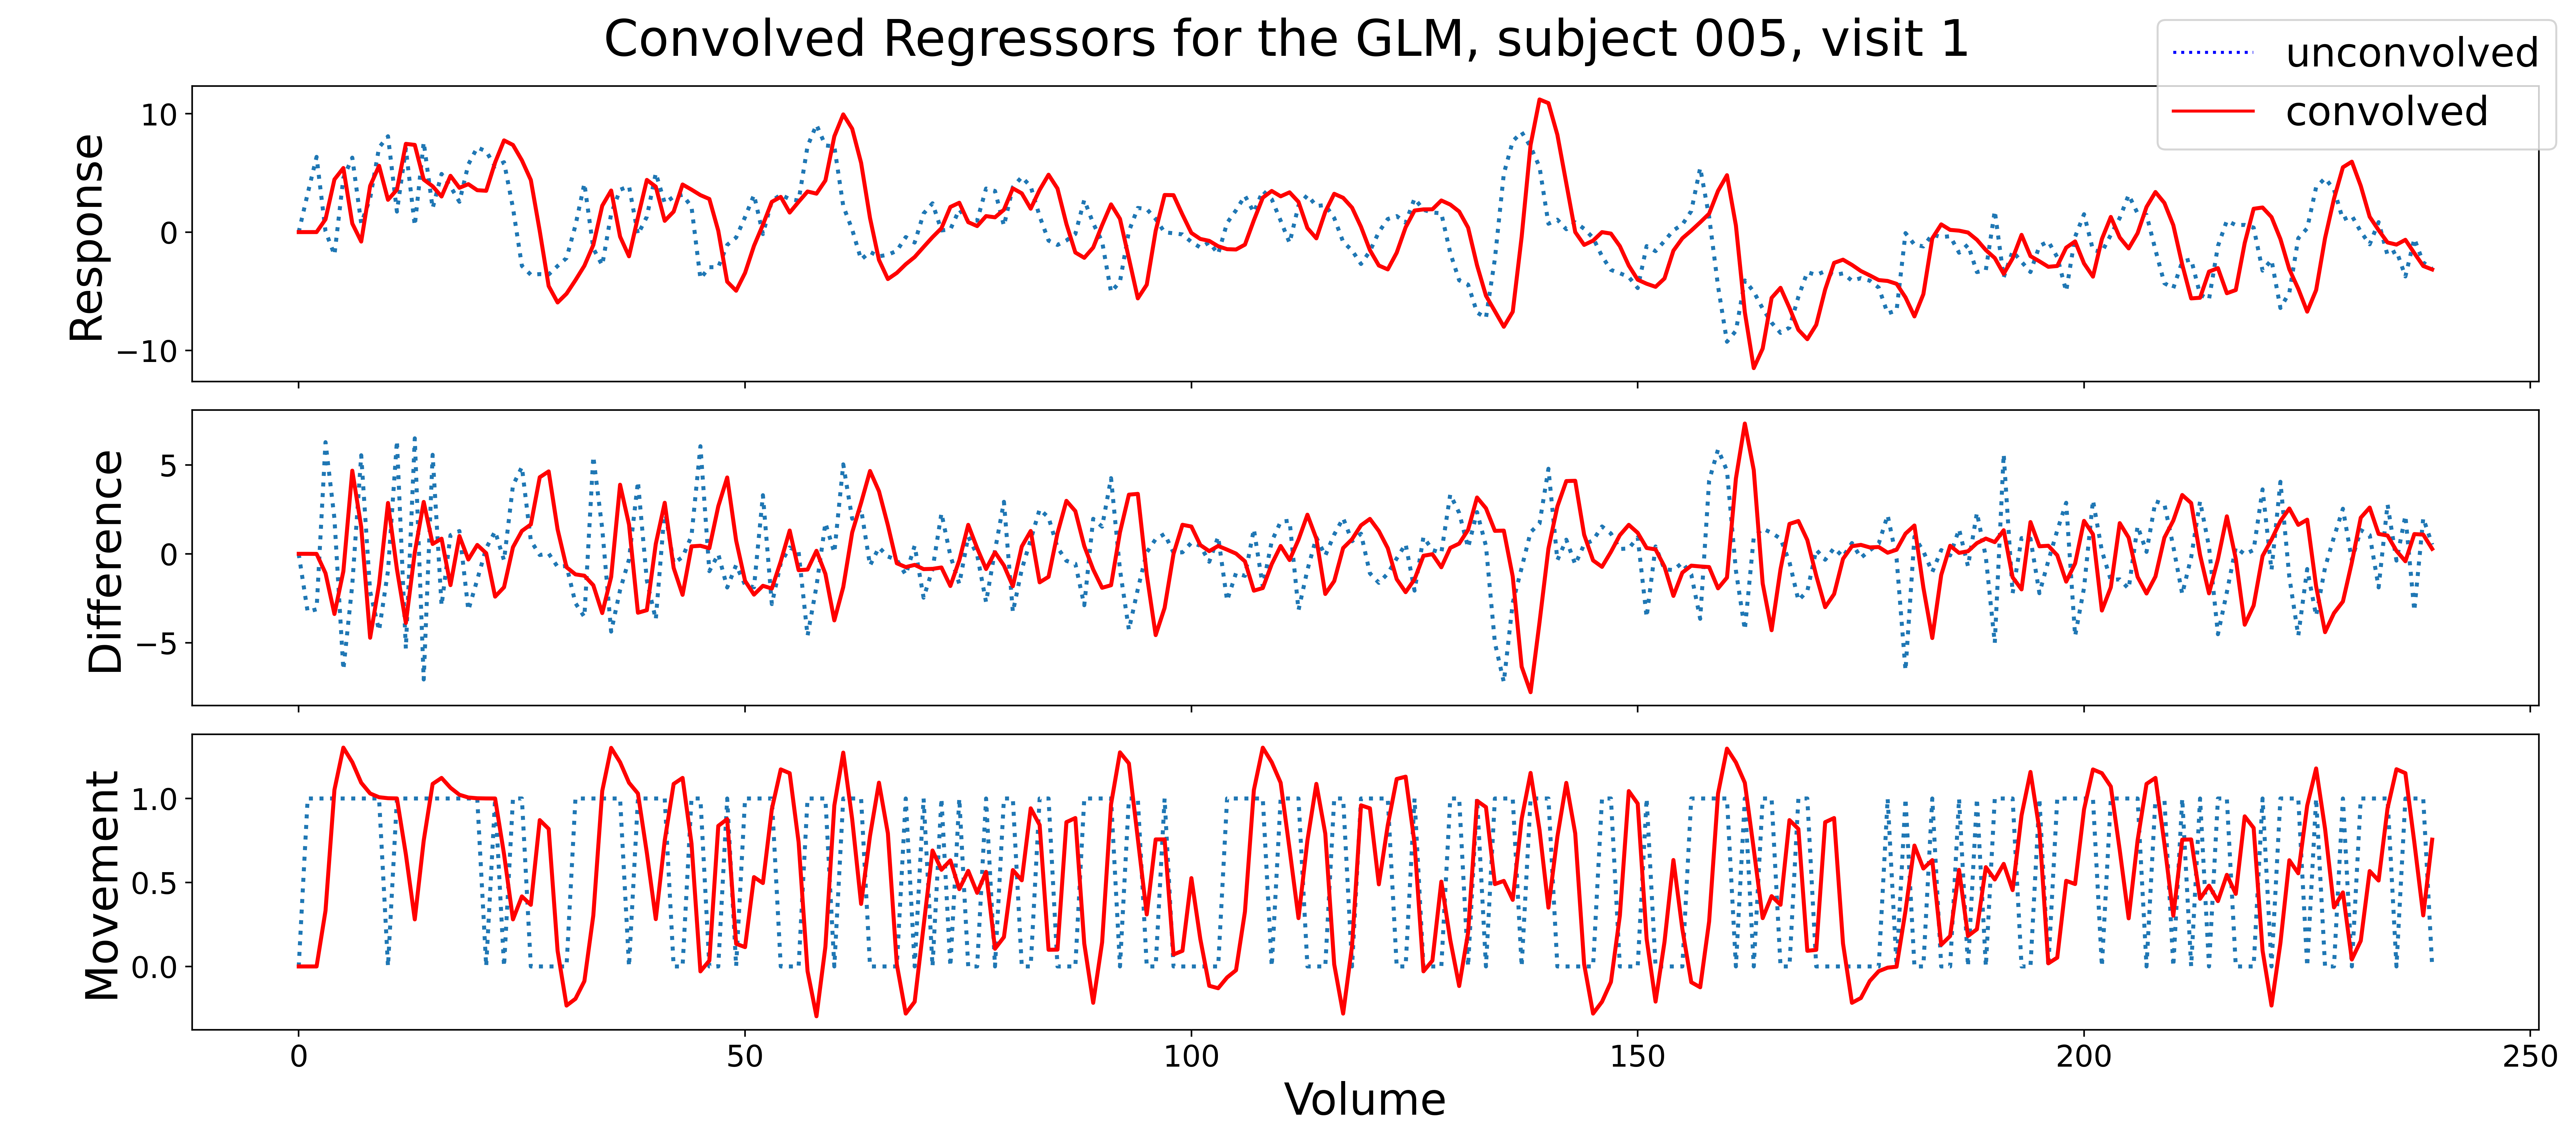

In [17]:
unconvolved_regressors = [
readCsv("responseArray.csv"),
readCsv("lag_1_differences.csv"),
readCsv("movement_regressors.csv"),
]
convolved_regressors = {
  'Response':readCsv('convolved_responses.csv'),
'Difference':readCsv('convolved_lag_1_differences.csv'),
'Movement':readCsv('convolved_movement_regressors.csv'),
}

color='red'
number = 15
fig, ax = plt.subplots(3,1, figsize = (18,8),sharex=True,dpi=500)
ax = ax.flatten()
for i, item in enumerate(convolved_regressors.items()):
  key, regressor = item
  if key == 'Movement':
    ax[i].plot(unconvolved_regressors[i][number,:],linewidth=2, linestyle='dotted', label='unconvolved')
  else:
    ax[i].plot(norm(unconvolved_regressors[i][number,:]),linewidth=2, linestyle='dotted',label='unconvolved')
  ax[i].plot(regressor[number,:],label = 'convolved',linewidth=2,color=color)
  ax[i].tick_params(labelsize=15)
  ax[i].set_ylabel(f"\n{key}", fontsize=22)
plt.xlabel("Volume", fontsize=22)


unsmoothed = mlines.Line2D([], [], color='blue', linestyle='dotted',label='unconvolved' )
smoothed = mlines.Line2D([], [], color=color, linestyle='solid',label='convolved')
fig.legend(handles=[unsmoothed, smoothed],fontsize=20,loc='upper right')
  #ax[i].set_title(key, fontsize=20)

responses_df = np.array(pd.read_csv('Carl_preprocessed_responses/preprocessed_response_details.csv', sep='\t'))
subject = responses_df[number][0]
visit = responses_df[number][1]
plt.suptitle(f"Convolved Regressors for the GLM, subject {subject[-3:]}, visit {visit[-1]}", fontsize=25)
plt.tight_layout()
plt.show()

# fig = plt.figure(figsize=(20,5))
# plt.plot(unconvolved_regressors[0][number,:])
# plt.plot(convolved_regressors['responses'][number,:])
# plt.xlabel("Volume", fontsize=15)
# plt.ylabel("Pain rating", fontsize=15)
# plt.title("The unconvolved regressor", fontsize=20)
# plt.show()


In [ ]:
    # font = 25

    # fig,axes = plt.subplots(2,1,figsize = (16,5),sharex=True)
    # ax = axes.flatten()
    # ax[0].plot(np.arange(len(design_matrices['response'])),norm(design_matrices['response']), label='predictions')
    # ax[0].plot(np.arange(len(design_matrices['response'])) ,norm(design_matrices['errors']),label='errors')
    # #ax[1].plot(np.arange(36*len(design_matrices['response']))/36.0 ,norm(expectations),label='original_response')
    # ax[1].plot(np.arange(36*len(design_matrices['response']))/36.0 ,savgol_filter(norm(expectations),8*36+1,3), label='original_response')

    # ax[0].tick_params(axis='y', labelsize=font/1.5)
    # ax[1].tick_params(axis='y', labelsize=font/1.5)
    # plt.xticks(np.arange(244)[::16],np.array(np.arange(0,244)[::16]*2.5).astype(int),rotation=90,fontsize=font/1.5)

    # ax[1].legend(fontsize=font/1.75,loc='upper left')
    # ax[0].legend(fontsize=font/1.75, loc='upper left')
    # plt.xlabel("seconds", fontsize=font)
    # fig.add_subplot(111, frameon=False)
    # # hide tick and tick label of the big axis
    # plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # plt.ylabel("Normalised \n magnitude", fontsize=font)    
    # plt.suptitle("Convolved RL regressors for use in the GLM, and the smoothed pain ratings", fontsize=font)
    # plt.tight_layout()
    # plt.show()


## Frequency Effects of Convolution

In [ ]:
def psd(response,fs=14.4):
    
  n = len(response)
  freq = rfftfreq(n, d=1./fs)
  freqs, psd = welch(response,fs=fs)
  psd = np.abs(psd)
  return freq, psd

number = 18
plt.plot(unconvolved_regressors[0][number])
plt.plot(convolved_regressors['responses'][number])
plt.show()
freq, PSD_Unconvolved = psd(unconvolved_regressors[0][number])
freq_2, PSD_convolved = psd(convolved_regressors['responses'][number])

plt.plot(freq,PSD_Unconvolved,label='unconvolved')
plt.plot(freq_2,PSD_convolved,label='convolved')
plt.legend()
